In [9]:
import torch
import torch.nn as nn
import importlib
import tiktoken

In [40]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length":256, # 1024-->256 (for local pc)
    "emb_dim":768,
    "n_layers":12,
    "n_heads":12,
    "drop_rate":0.1,
    "qkv_bias": False
}

In [10]:
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim = 0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [11]:
'Layer Normalization'
class LayerNorm(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))
  def forward(self, x):
    mean = x.mean(dim =-1, keepdim= True) # Mean Along Column
    var = x.var(dim =-1, keepdim= True, unbiased = False) # Variance Along Column
    normalizedX = (x-mean)/torch.sqrt(var+self.eps)  # Eps is small constant to prevent dividing by 0 during normalization
    return self.scale * normalizedX + self.shift

# Scale and shift are two trainable params of same dim as input that LLM automatically adjusts during training and this improves models performance on its training task

'GELU ACTIVATION FUNCTION'
class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return 0.5 * x * (1 + torch.tanh(
        torch.sqrt(torch.tensor(2 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))
    ))

'Feed Forward Neural Network'
class FeedForward(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(cfg["emb_dim"], 4*cfg["emb_dim"]), #Expansion
        nn.GELU(), # Activation
        nn.Linear(4*cfg["emb_dim"], cfg["emb_dim"]), # Compression
    )

  def forward(self, x):
    return self.layers(x)

In [12]:
'Masked Self Attention'
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

In [13]:
'TRANSFORMER BLOCK'
class TransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.attention = MultiHeadAttention(
        d_in = cfg["emb_dim"],
        d_out = cfg["emb_dim"],
        context_length = cfg["context_length"],
        dropout = cfg["drop_rate"],
        num_heads = cfg["n_heads"],
        qkv_bias= cfg["qkv_bias"]
    )
    self.feedforwardNN = FeedForward(cfg)
    self.normalization1 = LayerNorm(cfg["emb_dim"])
    self.normalization2 = LayerNorm(cfg["emb_dim"])
    self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

  def forward(self, x):
    shortcut = x
    x = self.normalization1(x)
    x = self.attention(x)  #Shape [batch_size, num_tokens, emb_size]
    x = self.drop_shortcut(x)
    x = shortcut + x # Add the original input block

    # Shortcut connection for feed forward block
    shortcut = x
    x = self.normalization2(x)
    x = self.feedforwardNN(x)
    x = self.drop_shortcut(x)
    x = shortcut + x
    return x

In [14]:
class GPTModel(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.tokenEmbeddings = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
    self.positionalEmbeddings = nn.Embedding(cfg["context_length"], cfg["emb_dim"]) #(1024x768)
    self.dropuoutEmbeddings = nn.Dropout(cfg["drop_rate"])

    'Transformer Block'
    self.transformerBlock = nn.Sequential(
    *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
   )
    'Layer Normalization'
    self.finalNormalization = LayerNorm(cfg["emb_dim"])
    self.out_head = nn.Linear(
        cfg["emb_dim"],
        cfg["vocab_size"], bias = False
    )

  def forward(self, inIdx):
    batchSize, seqLen  = inIdx.shape
    tokenEmbeddings = self.tokenEmbeddings(inIdx)
    positionalEmbeddings = self.positionalEmbeddings(torch.arange(seqLen, device = inIdx.device))
    x = tokenEmbeddings + positionalEmbeddings
    x = self.dropuoutEmbeddings(x)
    x = self.transformerBlock(x)
    x = self.finalNormalization(x)
    logits = self.out_head(x)
    return logits

In [15]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
output = model(batch)
print("Input Batch:\n", batch)
print("Input Dimensions:", batch.shape)
print("Output Batch:\n", output)
print("Output Dimensions:", output.shape)


Input Batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
Input Dimensions: torch.Size([2, 4])
Output Batch:
 tensor([[[-1.7956e-01,  2.8513e-01, -7.6136e-01,  ..., -4.8376e-01,
          -4.2502e-01, -1.7187e-01],
         [-6.2570e-01, -3.7481e-01, -9.7024e-01,  ...,  1.9165e-01,
          -1.3233e+00, -2.7649e-01],
         [ 5.1738e-01,  1.3861e-01,  2.4883e-01,  ...,  3.5054e-01,
          -7.7547e-02, -8.0083e-02],
         [-2.5663e-01, -6.9688e-01, -9.9481e-01,  ..., -4.4813e-02,
           6.1765e-02,  1.3463e-01]],

        [[-2.2387e-01,  1.1651e-01, -9.9837e-01,  ..., -1.5732e-01,
          -4.4797e-01, -2.8707e-02],
         [-8.7221e-01, -3.9391e-01, -1.1100e+00,  ...,  3.3034e-01,
          -9.2369e-02, -4.0911e-05],
         [ 4.5988e-01, -1.4278e-01, -1.2221e-01,  ...,  2.7497e-01,
           5.8283e-02, -8.9999e-02],
         [-6.2160e-01, -4.4856e-01, -4.7678e-01,  ..., -3.6523e-01,
           3.4399e-01, -3.8157e-01]]], grad_fn=<UnsafeViewBa

In [16]:
def generateText(model, idx, maxNewTokens, contextSize):
    # idx is (batch, numTokens) array of indices in the current context
    for _ in range(maxNewTokens):
        # Crop the current context if it exceeds the supported size
        idxCond = idx[:, -contextSize:]

        # Predictions
        with torch.no_grad():
            logits = model(idxCond)  # (batch, numTokens, vocabSize)

        # S1) Extract last vector
        logits = logits[:, -1, :]  # (batch, vocabSize)

        # S2) Apply softmax to get probabilities
        probs = torch.softmax(logits, dim=-1)

        # S3) Choose the highest probability
        idxNext = torch.argmax(probs, dim=-1, keepdim=True)  # (batch, 1)

        # S4) Append the new token to the sequence
        idx = torch.cat((idx, idxNext), dim=1)  # (batch, numTokens+1)

    return idx


# PART 1) MEASURING LOSS FUNCTION
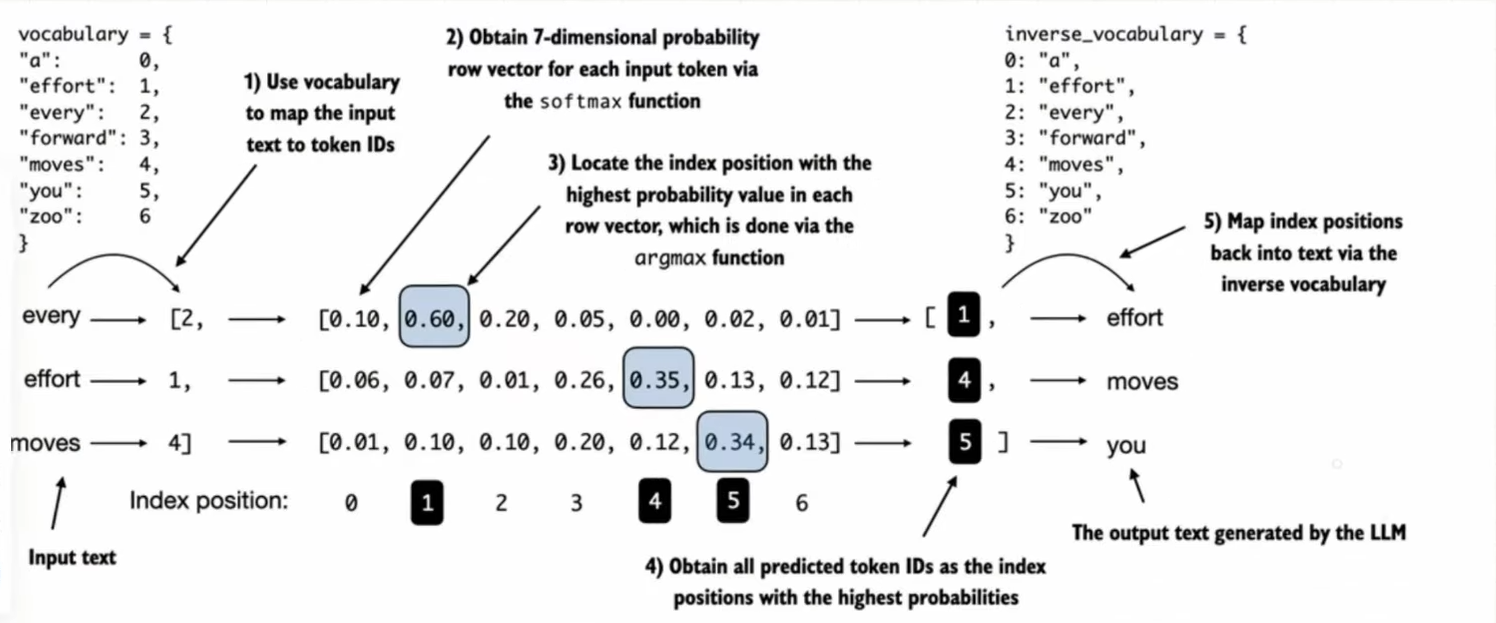

In [17]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length":256, # 1024-->256 (for local pc)
    "emb_dim":768,
    "n_layers":12,
    "n_heads":12,
    "drop_rate":0.1,
    "qkv_bias": False
}
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tokenEmbeddings): Embedding(50257, 768)
  (positionalEmbeddings): Embedding(256, 768)
  (dropuoutEmbeddings): Dropout(p=0.1, inplace=False)
  (transformerBlock): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feedforwardNN): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (normalization1): LayerNorm()
      (normalization2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1)

In [25]:
def textToTokenId(text, tokenizer):
  encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
  encodedTensor = torch.tensor(encoded).unsqueeze(0) # Adding batch dimension
  return encodedTensor
def tokenIdtoText(tokenId, tokenizer):
  flat = tokenId.squeeze(0) # Removing Batch dimension
  return tokenizer.decode(flat.tolist())

startContext = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

tokenIds = generateText(
    model = model,
    idx = textToTokenId(startContext, tokenizer),
    maxNewTokens=10,
    contextSize= GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", tokenIdtoText(tokenIds, tokenizer))


Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


# Calculating text generation loss: cross-entropy and perplexity

In [28]:
inputs = torch.tensor([[16833, 3626, 6100], # ["every effort moves"]
                       [40, 1107, 588]])    # ["I really like"]

targets = torch.tensor([[3626, 6100, 345],   # ["effort moves you"]
                        [1107, 588, 11311]]) # ["really like chocolates"]

In [32]:
with torch.no_grad():
  logits = model(inputs)
probs = torch.softmax(logits, dim = -1)
print(probs.shape) # (batchsize, numtokens, vocabsize)

torch.Size([2, 3, 50257])


In [33]:
tokenIds = torch.argmax(probs, dim = -1, keepdim= True)
print(tokenIds)

tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [39]:
# Decoding
print(f"Targets Batch 1: {tokenIdtoText(targets[0], tokenizer)}") # Ouput we wanted
print(f"Output Batch 1: {tokenIdtoText(tokenIds[0].flatten(), tokenizer)}") # Output we actually generated using our model before any training

Targets Batch 1:  effort moves you
Output Batch 1:  Armed heNetflix


# Cross Entropy Loss
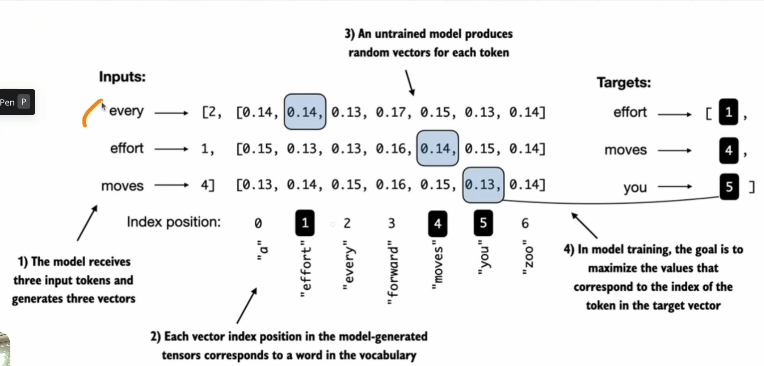

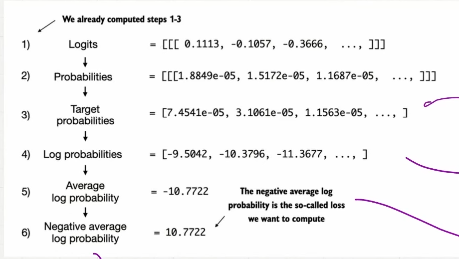

* The main aim of the model training is to minimize cross entropy loss so that each prob p11....p23 can become close to 1

Cross Entropy Loss

In [47]:
textIdx = 0 # First sequence in batch
targetProbs1 = probs[textIdx, [0,1,2], targets[textIdx]]
print(targetProbs1)

textIdx = 1 # Second batch
targetProbs2 = probs[textIdx, [0,1,2], targets[textIdx]]
print(targetProbs2)

# These values are p11, p12, .... p23 need to bring these values closs to 1

tensor([7.4536e-05, 3.1061e-05, 1.1563e-05])
tensor([1.0337e-05, 5.6771e-05, 4.7559e-06])


In [48]:
# Computing log values
logProbs = torch.log(torch.cat((targetProbs1, targetProbs2), dim=0))
print(logProbs)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7765, -12.2561])


In [50]:
# Computing Avg log prob
avgLogProbs = torch.mean(logProbs)
print(avgLogProbs)

tensor(-10.7940)


In [52]:
negiAvgLogProbs = avgLogProbs * -1
print(negiAvgLogProbs)
# we need to minimize this above value

tensor(10.7940)


# Method 2

In [54]:
print(logits.shape)
print(targets.shape)

torch.Size([2, 3, 50257])
torch.Size([2, 3])


In [57]:
flattenlogits = logits.flatten(0,1)
flattenTargets = targets.flatten()
print(flattenlogits)
print(flattenTargets)
print(flattenlogits.shape)
print(flattenTargets.shape)

tensor([[ 0.4563,  0.4571,  0.5112,  ..., -1.7877, -0.4626,  1.8593],
        [ 0.9484,  1.1312, -0.7120,  ...,  0.0359,  0.2971,  0.6373],
        [-1.4520,  0.7620, -0.4082,  ..., -0.4307,  0.1342, -0.3324],
        [-0.0543,  0.3813,  0.8036,  ...,  0.9010, -0.9466, -0.5107],
        [ 0.0641, -0.5329,  0.1522,  ..., -0.6887,  0.3105,  0.7379],
        [ 0.6410,  0.6360, -0.4710,  ..., -0.6618,  0.3070, -0.4971]])
tensor([ 3626,  6100,   345,  1107,   588, 11311])
torch.Size([6, 50257])
torch.Size([6])


In [58]:
loss = torch.nn.functional.cross_entropy(flattenlogits, flattenTargets)
print(loss)

tensor(11.3248)


In [60]:
import torch.nn.functional as F

# Cross entropy directly
loss1 = F.cross_entropy(flattenlogits, flattenTargets)
log_probs = F.log_softmax(flattenlogits, dim=-1)
loss2 = -log_probs[torch.arange(flattenTargets.size(0)), flattenTargets].mean()

print(loss1)
print(loss2)


tensor(11.3248)
tensor(11.3248)


In [62]:
perplexityScore = torch.exp(loss1)
print(perplexityScore)

tensor(82854.6719)
